In [1]:
import os
path_pipest = os.path.abspath('./')
n=0
while (not os.path.basename(path_pipest)=='pipest') and (n<6):
    path_pipest=os.path.dirname(path_pipest)
    n+=1 
if not os.path.basename(path_pipest)=='pipest':
    raise ValueError("path_pipest not found. Instead: {}".format(path_pipest))
path_sdhawkes=path_pipest+'/sdhawkes'
import sys
sys.path.append(path_sdhawkes+'/modelling/')
sys.path.append(path_sdhawkes+'/resources/')
import numpy as np
import matplotlib.pyplot as plt
#Import relevant modules from pipest
import model as sdmodel
import nonparam_estimation as nonparam_estim

openmp.omp_get_max_threads(): 4
openmp.omp_get_max_threads(): 4


In [2]:
list_of_n_states, n_events, n_levels = [1,1], 1, 2
model = sdmodel.SDHawkes(number_of_event_types=n_events,
                 number_of_lob_levels=n_levels,
                 volume_imbalance_upto_level=2,
                 list_of_n_states=list_of_n_states
                )
tot_n_states=model.state_enc.tot_n_states

nus = 0.015*np.random.randint(low=1,high=2,size=n_events)
a=4.90
alphas = np.random.uniform(a,a+0.01,size=(n_events, tot_n_states, n_events))
betas = np.random.uniform(5.9, 6.1,size=(n_events, tot_n_states, n_events))
model.set_hawkes_parameters(nus,alphas,betas)
phis = model.state_enc.generate_random_transition_prob(n_events=n_events)
model.set_transition_probabilities(phis)
kappas = np.random.lognormal(size=(tot_n_states,2*n_levels))
model.set_dirichlet_parameters(kappas)

Hawkes parameters have been set
SDHawkes: asymmetry in transition_probabilities = 0.9872923053405076
Transition probabilities have been set
Dirichlet parameters have been set


In [3]:
print("\nSIMULATION\n")
time_start = 0.0
time_end = time_start + 9000 #150 minutes
max_number_of_events = 20000
model.simulate(
    time_start, time_end,max_number_of_events=max_number_of_events,
    add_initial_cond=True,
    store_results=True, report_full_volumes=False)
time_end=float(model.simulated_times[-1])


SIMULATION

Simulation is being performed on the following machine:
 posix.uname_result(sysname='Linux', nodename='hpelitebook850g3', release='5.3.0-53-generic', version='#47~18.04.1-Ubuntu SMP Thu May 7 13:10:50 UTC 2020', machine='x86_64')
SDHawkes.simulate: initial conditions have been acknowledged
I am adding initial conditions on the negative time axis
sd_hawkes_powerlaw_simulation.simulate: start of initialisation
   Number of levels in the order book: 2
   number_of_initial_events=2
sd_hawkes_powerlaw_simulation: simulate: labelled_times and count have been initialised.
sd_hawkes_powerlaw_simulation: simulate: intensities have been initialised.
  intensities at start: [0.015]
  intensity_overall at start: 0.015000000000037872
sd_hawkes_powerlaw_simulation.simulate: start of simulation
  time_start=0.0,  time at start =0.0
 Simulation terminates. time at end =9036.37092577901,  num_of_event=2554
sd_hawkes_powerlaw_simulation: simulate. run_time=1.3 seconds


In [4]:
model.create_goodness_of_fit(type_of_input='simulated')

I am computing residuals in parallel. num_process: 1
goodness_of_fit.compute_residuals. component_e: 0; process_id: pid5429
Computation of residuals terminates. run_time=0.629798412322998


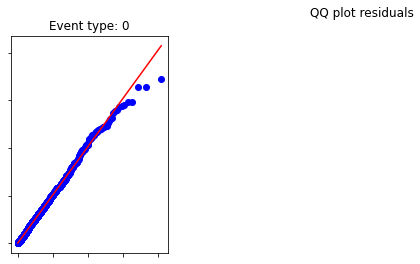

Kolmogorov-Smirnov test to check that the residuals are iid with distribution Exp(1)
event type=0, ks_answer: KstestResult(statistic=0.02761344238552177, pvalue=0.040816349683742974)
None
Anderson-Darling test to check distribution of residuals
Null hypothesis is "expon" 
Significance levels: [15.  10.   5.   2.5  1. ]
Critical values: [0.922 1.078 1.341 1.606 1.957]
event type=0, ad_stat: 0.4693092026773229
None


In [5]:
model.goodness_of_fit.qq_plot_residuals()
print(model.goodness_of_fit.ks_test_on_residuals())
print(model.goodness_of_fit.ad_test_on_residuals())

In [6]:
print("\nNON-PARAMETRIC ESTIMATION\n")
tmax=1.0e+02
tmin=1.0e-03
hmax=5.0e+01
hmin=1.0e-02
num_quadpnts = 200
num_gridpnts= 30
model.create_nonparam_estim(type_of_input='simulated',
                            num_quadpnts = num_quadpnts,
                            quad_tmax = tmax,
                            quad_tmin = tmin,
                            num_gridpnts = num_gridpnts,
                            grid_tmax = hmax,
                            grid_tmin = hmin,
                            two_scales=True,
                            tol=1.0e-6
                           )


NON-PARAMETRIC ESTIMATION

nonparam_estimation.EstimProcedure is being initialised
I am storing distribution of marks
I am storing transition probabilities
I am storing expected intensities
EstimProcedure has been successfully initialised


imp_coef=4.903225374728145
dec_coef=6.042954003953671
spectral_radii: [0.97229231]
expected intensity: [0.23872698]


/home/claudio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


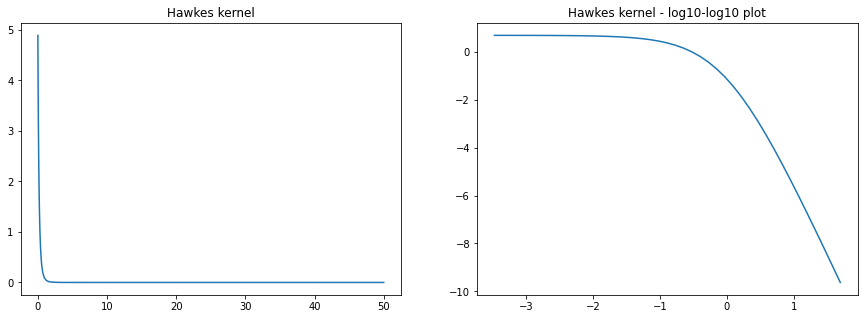

In [7]:
print('imp_coef={}'.format(model.impact_coefficients[0,0,0]))
print('dec_coef={}'.format(model.decay_coefficients[0,0,0]))
model.hawkes_kernel.store_L1_norm()
model.hawkes_kernel.store_spectral_radius()
print('spectral_radii: {}'.format(model.hawkes_kernel.spectral_radii))
print('expected intensity: {}'. format(model.nonparam_estim.expected_intensities))
sdkernel=model.impact_coefficients[0,0,0]\
*np.power(model.nonparam_estim.grid.partition +1.0, -model.decay_coefficients[0,0,0])
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(122)
idx=np.logical_and(np.log(model.nonparam_estim.grid.partition)/np.log(10)>=-4,np.log(model.nonparam_estim.grid.partition)/np.log(10)<=2.5)
t=model.nonparam_estim.grid.partition[idx]
x=np.log(model.nonparam_estim.grid.partition)[idx]/np.log(10)
y=np.log(sdkernel)[idx]/np.log(10)
ax.plot(x,y)
ax.set_title('Hawkes kernel - log10-log10 plot')
ax1=fig.add_subplot(121)
x=model.nonparam_estim.grid.partition[idx]
y=sdkernel[idx]
ax1.plot(x,y)
ax1.set_title('Hawkes kernel')
plt.show()

In [8]:
model.nonparam_estim.estimate_hawkes_kernel()

I am preparing estimation of hawkes kernel
I am storing non-singular expected jumps in parallel. num_processes: 1
I am estimating non-singular expected jumps for the component e=0. process_id: pid5436
Execution of non-singular expected jumps terminates. run_time=0.620826005935669
I am storing convolution kernels
I am storing matrix A
Estimation of hawkes kernel is now ready
I am performing estimation of hawkes kernel serially
I am solving for the component e=0. process_id: pid5414
Estimation of hawkes kernel terminates. run_time=0.0051419734954833984


In [9]:
print('Estimated values of the conditional law g: \n {}'.format(model.nonparam_estim.g_hat_at_gridpnts[0,0,0,:]))

Estimated values of the conditional law g: 
 [ 3.02678830e+03  2.56132119e+01  3.14886526e+01  3.97142695e+01
  3.26637407e+01  3.38388288e+01  3.26637407e+01  3.73640932e+01
  3.50139170e+01  3.14886526e+01  2.67883000e+01  3.14886526e+01
  2.44381238e+01  4.20644458e+01  4.32395339e+01  3.85391814e+01
  3.03135644e+01  5.02900627e+01  2.20879475e+01  2.67883000e+01
  3.14886526e+01  2.79633882e+01  2.56132119e+01  3.38388288e+01
  2.44381238e+01  2.67883000e+01  3.50139170e+01  2.67883000e+01
  2.67883000e+01  2.91384763e+01  3.11390817e+01  2.96709757e+01
  3.30974491e+01  3.24429919e+01  3.19917593e+01  3.19021004e+01
  3.18643970e+01  3.15334273e+01  3.10791251e+01  3.05025096e+01
  2.91908105e+01  2.92706198e+01  2.80825726e+01  2.69502783e+01
  2.56493889e+01  2.45757972e+01  2.28388379e+01  1.98794355e+01
  1.78932041e+01  1.54939626e+01  1.24084184e+01  9.19005290e+00
  6.32286806e+00  3.89379992e+00  4.62710739e+00  5.05263244e+00
  2.40963141e+00  2.34888612e-01 -1.73259557e

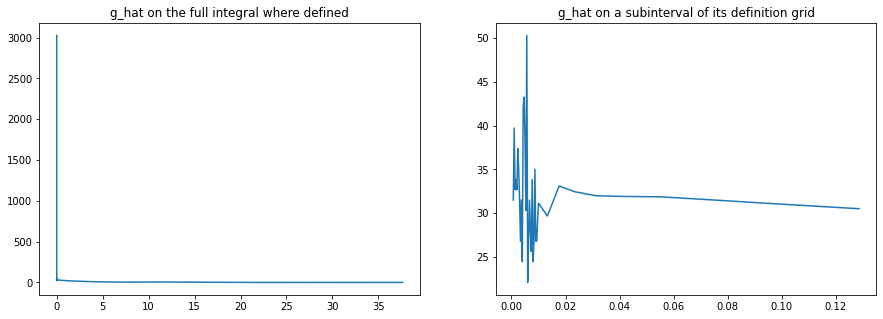

In [10]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(121)
t=model.nonparam_estim.grid.partition[:-1]
ghat=model.nonparam_estim.g_hat_at_gridpnts[0,0,0,:]
ax.plot(t,ghat)
ax.set_title('g_hat on the full integral where defined')
ax1=fig.add_subplot(122)
t=model.nonparam_estim.grid.partition[2:-21]
ghat=model.nonparam_estim.g_hat_at_gridpnts[0,0,0,2:-20]
ax1.plot(t,ghat)
ax1.set_title('g_hat on a subinterval of its definition grid')
plt.show()

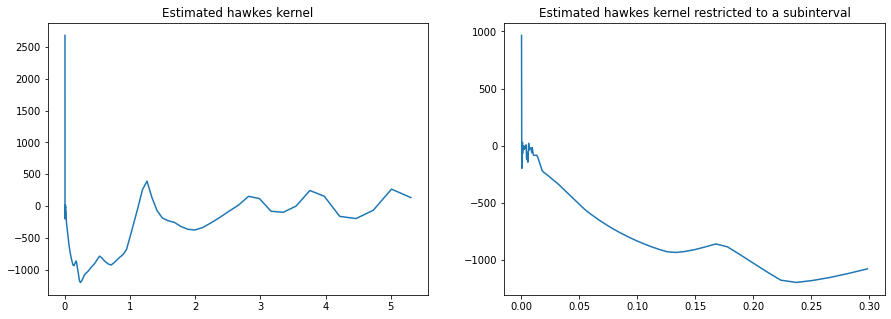

In [11]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(121)
t=model.nonparam_estim.quadrature.partition[:-51]
k=model.nonparam_estim.hawkes_kernel.values_at_quadpnts[0,0,0,:-50]
ax.plot(t,k)
ax.set_title('Estimated hawkes kernel')
ax1=fig.add_subplot(122)
t=model.nonparam_estim.quadrature.partition[30:-101]
k=model.nonparam_estim.hawkes_kernel.values_at_quadpnts[0,0,0,30:-100]
ax1.plot(t,k)
ax1.set_title('Estimated hawkes kernel restricted to a subinterval')
plt.show()